In [1]:
!pip install --upgrade ultralytics onnxruntime onnxruntime-gpu onnxslim roboflow supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.5/921.5 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.9/142.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66

The solutions are found from [Roboflow Discussion](https://github.com/roboflow/supervision/discussions/1789#discussioncomment-12229213)

In [2]:
import math
import time
import cv2
import numpy as np
import onnxruntime
import supervision as sv

# with NMS

In [3]:
from ultralytics import YOLO

# Load a model
yolo11seg_model = YOLO("yolo11s-seg.pt")

yolo11seg_model.export(
    format="onnx",
    nms=True,
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 19.7M/19.7M [00:00<00:00, 143MB/s] 


Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11s-seg summary (fused): 113 layers, 10,097,776 parameters, 0 gradients, 35.5 GFLOPs

PyTorch: starting from 'yolo11s-seg.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 300, 38), (1, 32, 160, 160)) (19.7 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.48...
ONNX: export success ✅ 5.7s, saved as 'yolo11s-seg.onnx' (38.8 MB)

Export complete (13.7s)
Results saved to /content
Predict:         yolo predict task=segment model=yolo11s-seg.onnx imgsz=640  
Validate:        yolo val task=segment model=yolo11s-seg.onnx imgsz=640 data=/ultralytics/ultralytics/cfg/datasets/coco.yaml  
Visualize:       https://netron.app


'yolo11s-seg.onnx'

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class YOLOv11nms:
    def __init__(self, path, conf_thres=0.4, num_masks=32):
        """
        Args:
            path (str): Path to the exported ONNX model.
            conf_thres (float): Confidence threshold for filtering detections.
            num_masks (int): Number of mask coefficients (should match export, e.g., 32).
        """
        self.conf_threshold = conf_thres
        self.num_masks = num_masks
        self.initialize_model(path)

    def initialize_model(self, path):
        # Create ONNX Runtime session with GPU (if available) or CPU.
        self.session = onnxruntime.InferenceSession(
            path, providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
        )
        self.get_input_details()
        self.get_output_details()

    def get_input_details(self):
        model_inputs = self.session.get_inputs()
        self.input_names = [inp.name for inp in model_inputs]
        self.input_shape = model_inputs[0].shape  # Expected shape: (1, 3, 640, 640)
        self.input_height = self.input_shape[2]
        self.input_width = self.input_shape[3]

    def get_output_details(self):
        model_outputs = self.session.get_outputs()
        self.output_names = [out.name for out in model_outputs]

    def prepare_input(self, image):
        # Record the original image dimensions.
        self.img_height, self.img_width = image.shape[:2]
        # Convert BGR (OpenCV format) to RGB.
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Resize to the model’s input size (e.g., 640x640).
        img = cv2.resize(img, (self.input_width, self.input_height))
        # Normalize pixel values to [0, 1].
        img = img.astype(np.float32) / 255.0
        # Convert from HWC to CHW format.
        img = img.transpose(2, 0, 1)
        # Add batch dimension: shape becomes (1, 3, 640, 640).
        input_tensor = np.expand_dims(img, axis=0)
        return input_tensor

    def inference(self, input_tensor):
        outputs = self.session.run(self.output_names, {self.input_names[0]: input_tensor})
        return outputs

    def segment_objects(self, image):
        """
        Processes an image and returns:
          - boxes: Bounding boxes (rescaled to original image coordinates).
          - scores: Confidence scores.
          - class_ids: Detected class indices.
          - masks: Binary segmentation masks (aligned with the original image).
        """
        # Preprocess the image.
        input_tensor = self.prepare_input(image)
        outputs = self.inference(input_tensor)

        # Process detection output.
        # Detection output shape is (1, 300, 38) (post-NMS & transposed).
        detections = np.squeeze(outputs[0], axis=0)  # Now shape: (300, 38)

        # Filter out detections below the confidence threshold.
        valid_mask = detections[:, 4] > self.conf_threshold
        detections = detections[valid_mask]

        if detections.shape[0] == 0:
            return np.array([]), np.array([]), np.array([]), np.array([])

        # Extract detection results.
        # boxes_model: boxes in model input coordinates (e.g., in a 640x640 space)
        boxes_model = detections[:, :4]  # Format: (x1, y1, x2, y2)
        scores = detections[:, 4]
        class_ids = detections[:, 5].astype(np.int64)
        mask_coeffs = detections[:, 6:]  # 32 mask coefficients

        # Rescale boxes for final drawing on the original image.
        boxes_draw = self.rescale_boxes(
            boxes_model,
            (self.input_height, self.input_width),
            (self.img_height, self.img_width)
        )

        # Process the mask output using the boxes in model coordinates.
        masks = self.process_mask_output(mask_coeffs, outputs[1], boxes_model)

        return boxes_draw, scores, class_ids, masks

    def process_mask_output(self, mask_coeffs, mask_feature_map, boxes_model):
        """
        Generates segmentation masks for each detection.

        Args:
            mask_coeffs (np.ndarray): (N, 32) mask coefficients for N detections.
            mask_feature_map (np.ndarray): Output mask feature map with shape (1, 32, 160, 160).
            boxes_model (np.ndarray): Bounding boxes in model input coordinates.

        Returns:
            mask_maps (np.ndarray): Binary masks for each detection, with shape
                                    (N, original_img_height, original_img_width).
        """
        # Squeeze the mask feature map: (1, 32, 160, 160) -> (32, 160, 160)
        mask_feature_map = np.squeeze(mask_feature_map, axis=0)
        # Reshape to (32, 25600) where 25600 = 160 x 160.
        mask_feature_map_reshaped = mask_feature_map.reshape(self.num_masks, -1)
        # Combine mask coefficients with the mask feature map.
        # Resulting shape: (N, 25600) → then reshape to (N, 160, 160)
        masks = sigmoid(np.dot(mask_coeffs, mask_feature_map_reshaped))
        masks = masks.reshape(-1, mask_feature_map.shape[1], mask_feature_map.shape[2])

        # Get mask feature map dimensions.
        mask_h, mask_w = mask_feature_map.shape[1], mask_feature_map.shape[2]
        # Rescale boxes from model coordinates (e.g., 640x640) to mask feature map coordinates (e.g., 160x160).
        scale_boxes = self.rescale_boxes(
            boxes_model,
            (self.input_height, self.input_width),
            (mask_h, mask_w)
        )
        # Also, compute boxes in original image coordinates for placing the mask.
        boxes_draw = self.rescale_boxes(
            boxes_model,
            (self.input_height, self.input_width),
            (self.img_height, self.img_width)
        )

        # Create an empty array for final masks with the same size as the original image.
        mask_maps = np.zeros((boxes_model.shape[0], self.img_height, self.img_width), dtype=np.uint8)

        # Determine blur size based on the ratio between the original image and the mask feature map.
        blur_size = (
            max(1, int(self.img_width / mask_w)),
            max(1, int(self.img_height / mask_h))
        )

        for i in range(boxes_model.shape[0]):
            # Get the detection box in mask feature map coordinates.
            sx1, sy1, sx2, sy2 = scale_boxes[i]
            sx1, sy1, sx2, sy2 = int(np.floor(sx1)), int(np.floor(sy1)), int(np.ceil(sx2)), int(np.ceil(sy2))

            # Get the corresponding box in the original image.
            ox1, oy1, ox2, oy2 = boxes_draw[i]
            ox1, oy1, ox2, oy2 = int(np.floor(ox1)), int(np.floor(oy1)), int(np.ceil(ox2)), int(np.ceil(oy2))

            # Crop the predicted mask region from the raw mask.
            cropped_mask = masks[i][sy1:sy2, sx1:sx2]
            if cropped_mask.size == 0 or (ox2 - ox1) <= 0 or (oy2 - oy1) <= 0:
                continue
            # Resize the cropped mask to the size of the detection box in the original image.
            resized_mask = cv2.resize(cropped_mask, (ox2 - ox1, oy2 - oy1), interpolation=cv2.INTER_CUBIC)
            # Apply a slight blur to smooth the mask edges.
            resized_mask = cv2.blur(resized_mask, blur_size)
            # Threshold the mask to obtain a binary mask.
            bin_mask = (resized_mask > 0.5).astype(np.uint8)
            # Place the binary mask into the correct location on the full mask.
            mask_maps[i, oy1:oy2, ox1:ox2] = bin_mask

        return mask_maps

    @staticmethod
    def rescale_boxes(boxes, input_shape, target_shape):
        """
        Rescales boxes from one coordinate space to another.

        Args:
            boxes (np.ndarray): Array of boxes (N, 4) with format [x1, y1, x2, y2].
            input_shape (tuple): (height, width) of the current coordinate space.
            target_shape (tuple): (height, width) of the target coordinate space.

        Returns:
            np.ndarray: Scaled boxes of shape (N, 4).
        """
        in_h, in_w = input_shape
        tgt_h, tgt_w = target_shape
        scale = np.array([tgt_w / in_w, tgt_h / in_h, tgt_w / in_w, tgt_h / in_h])
        return boxes * scale

    def __call__(self, image):
        # This allows you to call the instance directly, e.g.:
        # boxes, scores, class_ids, masks = detector(image)
        return self.segment_objects(image)

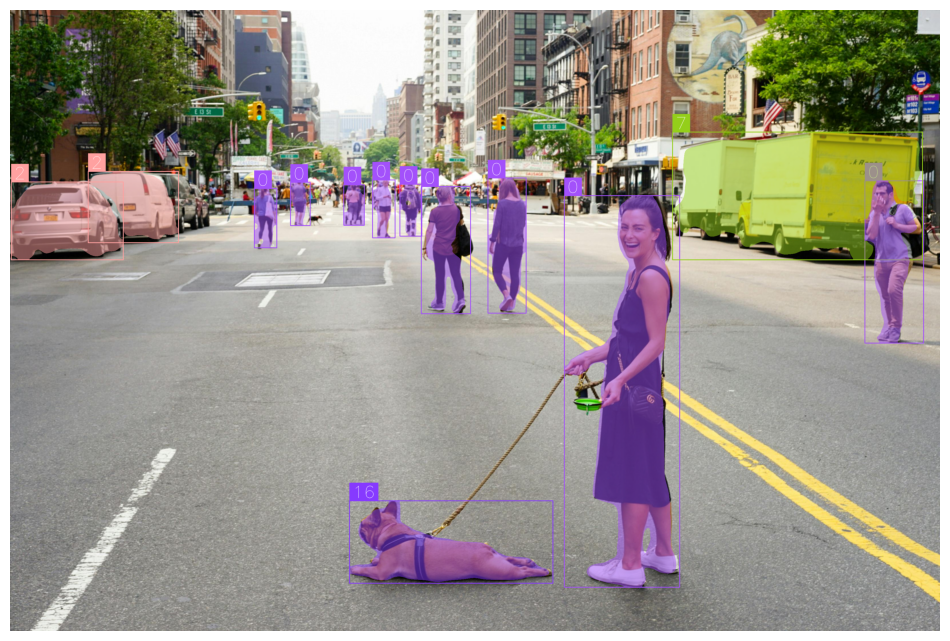

In [6]:
# Load the model and create InferenceSession
best_weights_path = "/content/yolo11s-seg.onnx"

detector = YOLOv11nms(best_weights_path, conf_thres=0.5)

img = cv2.imread("/content/target.jpg")
# Detect Objects (now returns bounding boxes, scores, class_ids, and segmentation masks)
boxes, scores, class_ids, masks = detector(img)

boolean_mask = masks.astype(bool)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_scale=2)
mask_annotator = sv.MaskAnnotator()
detections = sv.Detections(xyxy=boxes, confidence=scores, class_id=class_ids,mask=boolean_mask)
# optional
# detections = detections.with_nms(threshold=0.5)

annotate = box_annotator.annotate(scene=img.copy(), detections=detections)
annotate = label_annotator.annotate(scene=annotate, detections=detections)
annotate = mask_annotator.annotate(scene=annotate, detections=detections)

sv.plot_image(annotate)

# without NMS

In [7]:
from ultralytics import YOLO

# Load a model
yolo11seg_model = YOLO("yolo11s-seg.pt")

yolo11seg_model.export(
    format="onnx",
    # nms=True,
)

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11s-seg summary (fused): 113 layers, 10,097,776 parameters, 0 gradients, 35.5 GFLOPs

PyTorch: starting from 'yolo11s-seg.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 116, 8400), (1, 32, 160, 160)) (19.7 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.48...
ONNX: export success ✅ 3.3s, saved as 'yolo11s-seg.onnx' (38.8 MB)

Export complete (5.4s)
Results saved to /content
Predict:         yolo predict task=segment model=yolo11s-seg.onnx imgsz=640  
Validate:        yolo val task=segment model=yolo11s-seg.onnx imgsz=640 data=/ultralytics/ultralytics/cfg/datasets/coco.yaml  
Visualize:       https://netron.app


'yolo11s-seg.onnx'

In [8]:
def nms(boxes, scores, iou_threshold):
    # Sort by score
    sorted_indices = np.argsort(scores)[::-1]

    keep_boxes = []
    while sorted_indices.size > 0:
        # Pick the last box
        box_id = sorted_indices[0]
        keep_boxes.append(box_id)

        # Compute IoU of the picked box with the rest
        ious = compute_iou(boxes[box_id, :], boxes[sorted_indices[1:], :])

        # Remove boxes with IoU over the threshold
        keep_indices = np.where(ious < iou_threshold)[0]

        # print(keep_indices.shape, sorted_indices.shape)
        sorted_indices = sorted_indices[keep_indices + 1]

    return keep_boxes


def compute_iou(box, boxes):
    # Compute xmin, ymin, xmax, ymax for both boxes
    xmin = np.maximum(box[0], boxes[:, 0])
    ymin = np.maximum(box[1], boxes[:, 1])
    xmax = np.minimum(box[2], boxes[:, 2])
    ymax = np.minimum(box[3], boxes[:, 3])

    # Compute intersection area
    intersection_area = np.maximum(0, xmax - xmin) * np.maximum(0, ymax - ymin)

    # Compute union area
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union_area = box_area + boxes_area - intersection_area

    # Compute IoU
    iou = intersection_area / union_area

    return iou


def xywh2xyxy(x):
    # Convert bounding box (x, y, w, h) to bounding box (x1, y1, x2, y2)
    y = np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


class YOLOv11:
    def __init__(self, path, conf_thres=0.7, iou_thres=0.5, num_masks=32):
        self.conf_threshold = conf_thres
        self.iou_threshold = iou_thres
        self.num_masks = num_masks

        # Initialize model
        self.initialize_model(path)

    def __call__(self, image):
        return self.segment_objects(image)

    def initialize_model(self, path):
        self.session = onnxruntime.InferenceSession(path,
                                                    providers=['CUDAExecutionProvider',
                                                               'CPUExecutionProvider'])
        # Get model info
        self.get_input_details()
        self.get_output_details()

    def segment_objects(self, image):
        input_tensor = self.prepare_input(image)

        # Perform inference on the image
        outputs = self.inference(input_tensor)

        self.boxes, self.scores, self.class_ids, mask_pred = self.process_box_output(outputs[0])
        self.mask_maps = self.process_mask_output(mask_pred, outputs[1])

        return self.boxes, self.scores, self.class_ids, self.mask_maps

    def prepare_input(self, image):
        self.img_height, self.img_width = image.shape[:2]

        input_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize input image
        input_img = cv2.resize(input_img, (self.input_width, self.input_height))

        # Scale input pixel values to 0 to 1
        input_img = input_img / 255.0
        input_img = input_img.astype(np.float32)
        input_img = input_img.transpose(2, 0, 1)
        input_tensor = input_img[np.newaxis, :, :, :].astype(np.float32)

        return input_tensor

    def inference(self, input_tensor):
        start = time.perf_counter()
        outputs = self.session.run(self.output_names, {self.input_names[0]: input_tensor})

        return outputs

    def process_box_output(self, box_output):

        predictions = np.squeeze(box_output).T
        num_classes = box_output.shape[1] - self.num_masks - 4

        # Filter out object confidence scores below threshold
        scores = np.max(predictions[:, 4:4+num_classes], axis=1)
        predictions = predictions[scores > self.conf_threshold, :]
        scores = scores[scores > self.conf_threshold]

        if len(scores) == 0:
            return [], [], [], np.array([])

        box_predictions = predictions[..., :num_classes+4]
        mask_predictions = predictions[..., num_classes+4:]

        # Get the class with the highest confidence
        class_ids = np.argmax(box_predictions[:, 4:], axis=1)

        # Get bounding boxes for each object
        boxes = self.extract_boxes(box_predictions)

        # Apply non-maxima suppression to suppress weak, overlapping bounding boxes
        indices = nms(boxes, scores, self.iou_threshold)

        return boxes[indices], scores[indices], class_ids[indices], mask_predictions[indices]

    def process_mask_output(self, mask_predictions, mask_output):

        if mask_predictions.shape[0] == 0:
            return []

        mask_output = np.squeeze(mask_output)

        # Calculate the mask maps for each box
        num_mask, mask_height, mask_width = mask_output.shape  # CHW
        masks = sigmoid(mask_predictions @ mask_output.reshape((num_mask, -1)))
        masks = masks.reshape((-1, mask_height, mask_width))

        # Downscale the boxes to match the mask size
        scale_boxes = self.rescale_boxes(self.boxes,
                                   (self.img_height, self.img_width),
                                   (mask_height, mask_width))

        # For every box/mask pair, get the mask map
        mask_maps = np.zeros((len(scale_boxes), self.img_height, self.img_width))
        blur_size = (int(self.img_width / mask_width), int(self.img_height / mask_height))
        for i in range(len(scale_boxes)):

            scale_x1 = int(math.floor(scale_boxes[i][0]))
            scale_y1 = int(math.floor(scale_boxes[i][1]))
            scale_x2 = int(math.ceil(scale_boxes[i][2]))
            scale_y2 = int(math.ceil(scale_boxes[i][3]))

            x1 = int(math.floor(self.boxes[i][0]))
            y1 = int(math.floor(self.boxes[i][1]))
            x2 = int(math.ceil(self.boxes[i][2]))
            y2 = int(math.ceil(self.boxes[i][3]))

            scale_crop_mask = masks[i][scale_y1:scale_y2, scale_x1:scale_x2]
            crop_mask = cv2.resize(scale_crop_mask,
                              (x2 - x1, y2 - y1),
                              interpolation=cv2.INTER_CUBIC)

            crop_mask = cv2.blur(crop_mask, blur_size)

            crop_mask = (crop_mask > 0.5).astype(np.uint8)
            mask_maps[i, y1:y2, x1:x2] = crop_mask

        return mask_maps

    def extract_boxes(self, box_predictions):
        # Extract boxes from predictions
        boxes = box_predictions[:, :4]

        # Scale boxes to original image dimensions
        boxes = self.rescale_boxes(boxes,
                                   (self.input_height, self.input_width),
                                   (self.img_height, self.img_width))

        # Convert boxes to xyxy format
        boxes = xywh2xyxy(boxes)

        # Check the boxes are within the image
        boxes[:, 0] = np.clip(boxes[:, 0], 0, self.img_width)
        boxes[:, 1] = np.clip(boxes[:, 1], 0, self.img_height)
        boxes[:, 2] = np.clip(boxes[:, 2], 0, self.img_width)
        boxes[:, 3] = np.clip(boxes[:, 3], 0, self.img_height)

        return boxes


    def get_input_details(self):
        model_inputs = self.session.get_inputs()
        self.input_names = [model_inputs[i].name for i in range(len(model_inputs))]

        self.input_shape = model_inputs[0].shape
        self.input_height = self.input_shape[2]
        self.input_width = self.input_shape[3]
        return self.input_names, self.input_shape, self.input_height, self.input_width

    def get_output_details(self):
        model_outputs = self.session.get_outputs()
        self.output_names = [model_outputs[i].name for i in range(len(model_outputs))]
        return self.output_names

    @staticmethod
    def rescale_boxes(boxes, input_shape, image_shape):
        # Rescale boxes to original image dimensions
        input_shape = np.array([input_shape[1], input_shape[0], input_shape[1], input_shape[0]])
        boxes = np.divide(boxes, input_shape, dtype=np.float32)
        boxes *= np.array([image_shape[1], image_shape[0], image_shape[1], image_shape[0]])

        return boxes

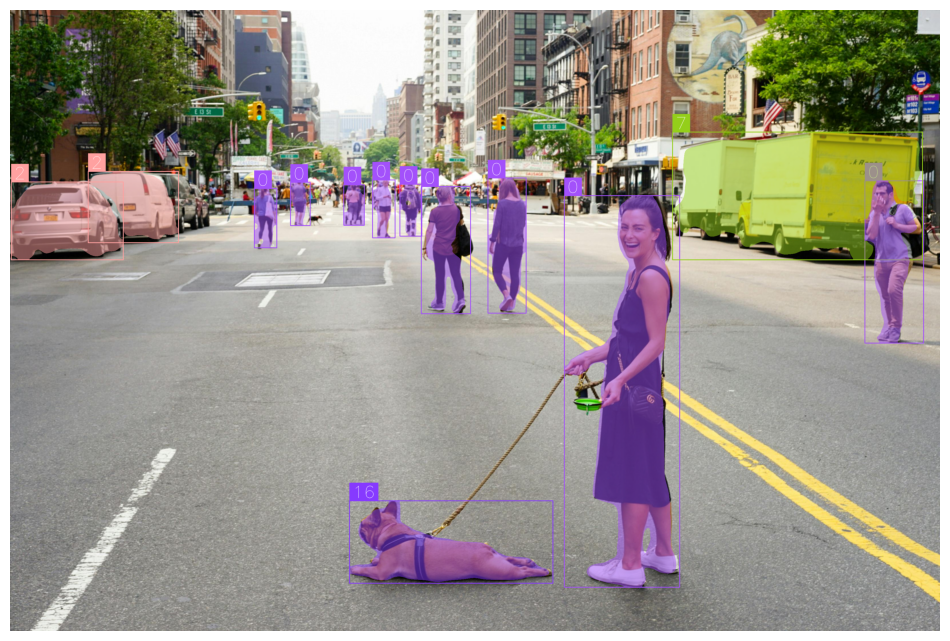

In [9]:
# Load the model and create InferenceSession
best_weights_path = "/content/yolo11s-seg.onnx"

detector = YOLOv11(best_weights_path, conf_thres=0.5, iou_thres=0.5)

img = cv2.imread("/content/target.jpg")
# Detect Objects (now returns bounding boxes, scores, class_ids, and segmentation masks)
boxes, scores, class_ids, masks = detector(img)

boolean_mask = masks.astype(bool)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_scale=2)
mask_annotator = sv.MaskAnnotator()
detections = sv.Detections(xyxy=boxes, confidence=scores, class_id=class_ids,mask=boolean_mask)
# optional
# detections = detections.with_nms(threshold=0.5)

annotate = box_annotator.annotate(scene=img.copy(), detections=detections)
annotate = label_annotator.annotate(scene=annotate, detections=detections)
annotate = mask_annotator.annotate(scene=annotate, detections=detections)

sv.plot_image(annotate)

# with NMS Web implimentation in JS/TS

Try it -> https://yolo11s-seg-web-onnx.vercel.app

Give it a star ⭐ -> https://github.com/pranta-barua007/yolo11s-seg-web-onnx